<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_pelvis_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1dE1shrnGY7eJsPU_CbbmSIycktAByQuN/view?usp=sharing


Downloading...
From (original): https://drive.google.com/uc?id=1dE1shrnGY7eJsPU_CbbmSIycktAByQuN
From (redirected): https://drive.google.com/uc?id=1dE1shrnGY7eJsPU_CbbmSIycktAByQuN&confirm=t&uuid=b5b80670-bab2-4ebf-830b-4601f05a7eaa
To: /content/pelvis.zip
100% 10.8G/10.8G [02:11<00:00, 82.5MB/s]


In [ ]:
!unzip -q pelvis.zip

replace content/Task1/pelvis/1PC095/mr.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from scipy.ndimage import zoom

class MRCTDataset(Dataset):
    def __init__(self, data_dir, target_size=(128, 128, 128)):
        """
        初始化數據集
        Args:
            data_dir (str): MRI 和 CT 數據的根目錄。
            target_size (tuple): 將 MRI 和 CT 影像調整為的固定尺寸。
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.samples = [
            os.path.join(root)
            for root, _, files in os.walk(data_dir)
            if "mr.nii.gz" in files and "ct.nii.gz" in files
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        根據索引返回一組 MR 和 CT 影像。
        Args:
            idx (int): 數據的索引。
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: MR 和 CT 的張量形式。
        """
        sample_path = self.samples[idx]

        # 加載 MRI 和 CT 影像
        mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
        ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

        # Z-score 標準化
        mr = self._normalize(mr)
        ct = self._normalize(ct)

        # 調整或填充影像大小
        mr = self._resize_or_pad(mr, self.target_size)
        ct = self._resize_or_pad(ct, self.target_size)

        # 轉換為 PyTorch 張量並增加通道維度
        mr = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)
        ct = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)

        return mr, ct

    def _normalize(self, image):
        """
        Z-score 標準化影像數據。
        Args:
            image (np.ndarray): 輸入影像。
        Returns:
            np.ndarray: 標準化的影像。
        """
        if np.std(image) != 0:
            return (image - np.mean(image)) / np.std(image)
        else:
            return image

    def _resize_or_pad(self, image, desired_shape):
        """
        調整影像大小或填充至固定大小。
        Args:
            image (np.ndarray): 輸入影像。
            desired_shape (tuple): 目標大小。
        Returns:
            np.ndarray: 調整或填充後的影像。
        """
        current_shape = image.shape
        scale = [d / c for d, c in zip(desired_shape, current_shape)]
        resized_image = zoom(image, scale, order=1)  # 調整大小

        # 填充影像至目標大小
        padded_image = np.zeros(desired_shape, dtype=resized_image.dtype)
        pad_slices = tuple(slice(0, min(dim, resized_image.shape[i])) for i, dim in enumerate(desired_shape))
        padded_image[pad_slices] = resized_image[:desired_shape[0], :desired_shape[1], :desired_shape[2]]

        return padded_image


In [4]:
## Data split
from sklearn.model_selection import train_test_split
import shutil

data_path = "/content/content/Task1/pelvis"
output_root = "/content/split"  # 輸出目錄

# 創建輸出資料夾
os.makedirs(output_root, exist_ok=True)
os.makedirs(os.path.join(output_root, "train"), exist_ok=True)
os.makedirs(os.path.join(output_root, "validation"), exist_ok=True)
os.makedirs(os.path.join(output_root, "test"), exist_ok=True)

# 獲取所有樣本資料夾名稱
samples = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]

# 按照 70:15:15 的比例分割
train_samples, test_samples = train_test_split(samples, test_size=0.3, random_state=42)
validation_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=42)

print(f"Total samples: {len(samples)}")
print(f"Train samples: {len(train_samples)}, Validation samples: {len(validation_samples)}, Test samples: {len(test_samples)}")

# 定義拷貝函數
def move_samples(samples, output_dir):
    for sample in samples:
        src_path = os.path.join(data_path, sample)  # 原始路徑
        dst_path = os.path.join(output_dir, sample)  # 目標路徑
        if os.path.exists(dst_path):
            print(f"Sample {sample} already exists in {output_dir}, skipping.")
            continue
        shutil.copytree(src_path, dst_path)  # 拷貝整個資料夾
        # print(f"Moved {sample} to {output_dir}")

# 將樣本移動到各自的資料夾
move_samples(train_samples, os.path.join(output_root, "train"))
move_samples(validation_samples, os.path.join(output_root, "validation"))
move_samples(test_samples, os.path.join(output_root, "test"))

print("Data split and moved successfully!")


Total samples: 181
Train samples: 126, Validation samples: 27, Test samples: 28
Sample 1PA052 already exists in /content/split/train, skipping.
Sample 1PA029 already exists in /content/split/train, skipping.
Sample 1PA048 already exists in /content/split/train, skipping.
Sample 1PA110 already exists in /content/split/train, skipping.
Sample overview already exists in /content/split/train, skipping.
Sample 1PC078 already exists in /content/split/train, skipping.
Sample 1PC038 already exists in /content/split/train, skipping.
Sample 1PC022 already exists in /content/split/train, skipping.
Sample 1PC015 already exists in /content/split/train, skipping.
Sample 1PA093 already exists in /content/split/train, skipping.
Sample 1PA127 already exists in /content/split/train, skipping.
Sample 1PA182 already exists in /content/split/train, skipping.
Sample 1PA060 already exists in /content/split/train, skipping.
Sample 1PA173 already exists in /content/split/train, skipping.
Sample 1PC093 already 

找到 125 個樣本
前 5 個樣本路徑： ['/content/split/train/1PA148', '/content/split/train/1PA086', '/content/split/train/1PC045', '/content/split/train/1PC084', '/content/split/train/1PA141']
MR shape: torch.Size([1, 128, 128, 128]), CT shape: torch.Size([1, 128, 128, 128])
MR min: -0.8565142750740051, max: 8.077162742614746, mean: -0.008537482470273972
CT min: -1.1409492492675781, max: 3.782966375350952, mean: -0.010503660887479782


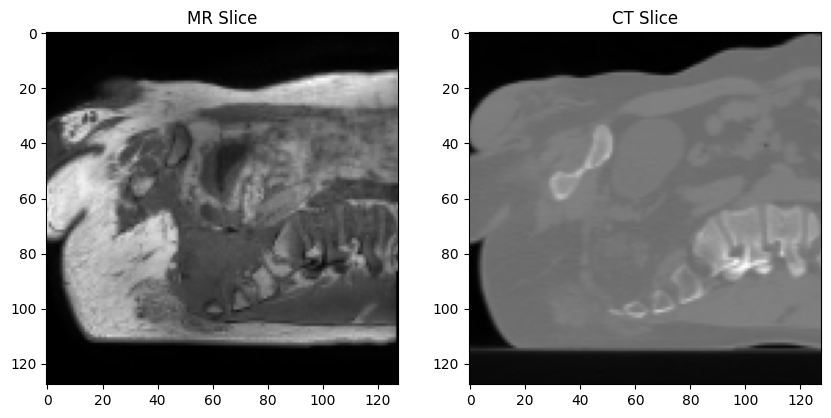

In [5]:
#########################
dataset = MRCTDataset("/content/split/train")
print(f"找到 {len(dataset)} 個樣本")
print("前 5 個樣本路徑：", dataset.samples[:5])

mr, ct = dataset[0]  # 取得第一筆數據
print(f"MR shape: {mr.shape}, CT shape: {ct.shape}")
print(f"MR min: {mr.min()}, max: {mr.max()}, mean: {mr.mean()}")
print(f"CT min: {ct.min()}, max: {ct.max()}, mean: {ct.mean()}")

import matplotlib.pyplot as plt

def visualize_sample(mr, ct, slice_idx=64):
    """
    顯示 MRI 和 CT 的中間橫截面
    """
    mr_slice = mr[0, slice_idx, :, :].numpy()
    ct_slice = ct[0, slice_idx, :, :].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(mr_slice, cmap="gray")
    axes[0].set_title("MR Slice")
    axes[1].imshow(ct_slice, cmap="gray")
    axes[1].set_title("CT Slice")
    plt.show()

mr, ct = dataset[0]  # 取第一筆
visualize_sample(mr, ct)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Swin Transformer Block (簡化版，適用於3D)
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_size):
        super(SwinTransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.window_size = input_size // 4  # 分割窗口，根據3D的尺寸調整

    def forward(self, x):
        b, c, d, h, w = x.shape  # 3D 輸入
        x = x.view(b, -1, c)  # 展平為序列
        x = self.norm(x)
        x = self.fc(x)
        return x.view(b, c, d, h, w)  # 還原為 3D

# MSEP 網路
class MSEP(nn.Module):
    def __init__(self):
        super(MSEP, self).__init__()
        # Encoder 部分
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU()
        )
        # Skip 連接部分 + RDSformer
        self.skip = SwinTransformerBlock(128, input_size=160)
        # Decoder 部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1),  # 使用3D反卷積
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1)  # 使用3D反卷積
        )

    def forward(self, x):
        enc = self.encoder(x)
        skip = self.skip(enc)  # 加入 skip connection
        dec = self.decoder(skip)
        return dec

# Initialize model
model = MSEP()

# Test the model with dummy data (e.g., [Batch Size, Channel, Depth, Height, Width])
dummy_input = torch.randn(1, 1, 128, 128, 128)  # 假設數據大小是 [1, 1, 128, 128, 128]
output = model(dummy_input)

print("Output shape:", output.shape)  # 應該返回符合預期的 3D 輸出


Output shape: torch.Size([1, 1, 128, 128, 128])


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(input_image, target_image, predicted_image, epoch, idx, batch_idx=0, max_slices=20):
    """
    視覺化輸入影像、目標影像與預測影像，只顯示中間的切片。
    """
    input_image = input_image[batch_idx, 0].cpu().detach().numpy()
    target_image = target_image[batch_idx, 0].cpu().detach().numpy()
    predicted_image = predicted_image[batch_idx, 0].cpu().detach().numpy()

    num_slices = input_image.shape[0]

    # 確保顯示的是中間的 max_slices 張切片
    mid_start = (num_slices - max_slices) // 2
    mid_end = mid_start + max_slices
    slice_indices = np.arange(mid_start, mid_end)

    fig, axes = plt.subplots(len(slice_indices), 3, figsize=(10, len(slice_indices) * 3))
    axes = np.atleast_2d(axes)

    for i, slice_idx in enumerate(slice_indices):
        axes[i, 0].imshow(input_image[slice_idx], cmap="gray")
        axes[i, 0].set_title(f"Input MR - Slice {slice_idx}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(target_image[slice_idx], cmap="gray")
        axes[i, 1].set_title(f"Target CT - Slice {slice_idx}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(predicted_image[slice_idx], cmap="gray")
        axes[i, 2].set_title(f"Predicted CT - Slice {slice_idx}")
        axes[i, 2].axis("off")

    plt.suptitle(f"Epoch {epoch}, Batch {idx}, Patient {batch_idx}")
    plt.tight_layout()
    plt.show()


In [8]:
import os

def save_checkpoint(epoch, val_loss, optimizer, model, path):
    filename = path
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
    }, filename)
    print(f"Checkpoint saved at {filename}")

def load_checkpoint(model, optimizer, path, device='cuda'):
    if not os.path.exists(path):
          print(f"Checkpoint file '{path}' does not exist. Starting from scratch.")
          return model, optimizer, 0, float('inf')  # 返回初始值
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    print(f"Checkpoint loaded from {path}, starting from epoch {epoch+1}" )
    return model, optimizer, epoch, val_loss


In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# 優化器與損失函數
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # 學習率調整
criterion = nn.L1Loss()

# 訓練參數
epochs = 10
best_loss = float("inf")

train_path = "/content/split/train"
valid_path = "/content/split/validation"
test_path = "/content/split/test"

train_dataset = MRCTDataset(train_path)
valid_dataset = MRCTDataset(valid_path)
test_dataset = MRCTDataset(test_path)


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)

for mr, ct in train_loader:
    print(f"MR shape: {mr.shape}, CT shape: {ct.shape}")
    break

# load checkpoint


start_epoch = 0
if os.path.exists("checkpoint_full.pth"):
  model, optimizer, start_epoch, best_val_loss = load_checkpoint(model, optimizer, "checkpoint_full.pth", device='cuda')
  model.to(device)


for epoch in range(start_epoch, epochs):
    # 訓練階段
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for mr, ct in progress_bar:
        mr, ct = mr.to(device), ct.to(device)
        optimizer.zero_grad()
        output = model(mr)
        loss = criterion(output, ct)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    # if epoch % 5 == 0:  # 每 5 個 epoch 可視化一次
    visualize_results(mr, ct, output, epoch, idx=1, batch_idx=0)


    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Train Loss: {avg_train_loss}")

    # 驗證階段
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mr, ct in val_loader:
            mr, ct = mr.to(device), ct.to(device)
            output = model(mr)
            loss = criterion(output, ct)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Validation Loss: {avg_val_loss}")
    save_checkpoint(epoch, avg_val_loss, optimizer, model, "checkpoint_full.pth")





MR shape: torch.Size([2, 1, 128, 128, 128]), CT shape: torch.Size([2, 1, 128, 128, 128])


Epoch 1/10:  75%|███████▍  | 47/63 [06:57<02:22,  8.89s/it, loss=0.322]


EOFError: Compressed file ended before the end-of-stream marker was reached